In the previous [post](https://lucasvw.github.io/posts/14_mlp/) we went through a simple MLP language model. We looked in detail at embeddings, and how they can be used to overcome the *curse of dimensionality* encountered for n-gram based models.

In this post we are going to have a look at recurrent neural networks as they are very similar to the MLP language model we have encountered. Additionally, we will have a look at a long short-term memory (LSTM) network.

## Data

Everything starts with training data, for a description see the earlier [post](https://lucasvw.github.io/posts/13_ngram/)

In [ ]:
#| code-fold: true

import random
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.ngram import *

In [ ]:
########### Load the data ###########
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

with open(path, 'r') as f:
    lines = f.read().splitlines()
    
random.seed(42)
random.shuffle(lines)

train_size=0.8
val_size=0.1

train_lines = lines[0:int(train_size * len(lines))]
val_lines = lines[int(train_size * len(lines)): int((train_size + val_size) * len(lines))]

### Create vocabulary and mappings ###
unique_chars = list(set("".join(lines)))
unique_chars.sort()
vocabulary = ['.'] + unique_chars

c2i = {c:i for i, c in enumerate(vocabulary)}
i2c = {i:c for i, c in enumerate(vocabulary)}

def get_dls(bs, context_length):
    train_ds = NgramDataset(train_lines, c2i, n=context_length+1)
    val_ds = NgramDataset(val_lines, c2i, n=context_length+1)
    train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=bs, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs*2, num_workers=4)
    dls = DataLoaders(train_loader, val_loader)
    return dls

## From MLP to RNN, a small change

The MLP model we encountered last post, used an embedding layer to turn the tokens from the context (in the image below of length 3) into vectors. These vectors then got concatenated, and passed through a hidden layer and an output layer (mapping the activations to the size of the vocabulary):

![](arch.png){width=600}

For an RNN, we also start-off by turning our integers into vectors making use of a single embedding layer. However, instead of concatenating the result and passing it through a single hidden layer, we *iteratively feed the embedding activations through a single hidden layer*. Each time moving on to (the embedding activations of) the next token and adding the activations obtained from the previous iteration. The first time I learned about the fact that we are simply adding these activations, I was pretty surprised: how can you expect to get anything meaningful by simple adding activations from two layers together? As it turns out, in neural network literature it happens quite often that combining of things simply happens by element-wise addition.

![](rnn.drawio.png){width=600}

Once all the context has been processed in this way, we finalize with an output layer similar to what we did for the MLP model. 

Let's put this into code:

In [ ]:
class FixedContextRNN(nn.Module):
    
    def __init__(self, c2i, hidden_size=10):
        super().__init__()
        self.c2i = c2i
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        input1 = F.relu(self.input2hidden(x[:,0]))
        input2 = F.relu(self.input2hidden(x[:,1]))
        input3 = F.relu(self.input2hidden(x[:,2]))
        
        out = F.relu(self.hidden2hidden(input1))
        out = F.relu(self.hidden2hidden(out + input2))
        out = F.relu(self.hidden2hidden(out + input3))
        
        return self.hidden2out(out)

Observe that both the embedding dimension and the size of the hidden layer need to be equal (`hidden_size`). This is because the activations from both these layers are added together and thus need to be of equal shape. This also means that there is just one hyperparameter influencing the amount of parameters in this network.

We can generalize this model a bit, and make it so that it accepts data of arbitrary context length:

In [ ]:
class VariableContextRNN(nn.Module):
    
    def __init__(self, c2i, context_length, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)           # [bs, context_length, hidden_size]
        # create dummy hidden-layer activations for the very first token 
        h = torch.zeros((x.shape[0], self.hidden_size)).to(device)
        
        for i in range(x.shape[1]):
            h = F.relu(self.hidden2hidden(h + inputs[:,i,:])) # [bs, hidden_size]
        return self.hidden2out(h)               # [bs, classes]

Let's see how well this model trains with a similar configuration to the first MLP we build in the previous [post](https://lucasvw.github.io/posts/14_mlp/#using-embeddings-effectively) (context length of 3 and a hidden size of 50):

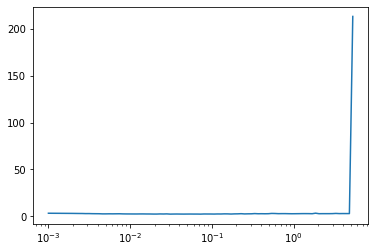

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-3
bs     = 500

# Hyperparameters
context_length = 3
n_h            = 50

dls = get_dls(bs, context_length)
rnn = VariableContextRNN(c2i, context_length, n_h)

lrfind = LRFindS(mult=1.1)

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=[DeviceS(device), lrfind])
l.fit(epochs, lr=lr)
lrfind.plot()

epoch,mode,loss
0,train,2.620
0,eval,2.302
1,train,2.273
1,eval,2.242
2,train,2.229
2,eval,2.216
3,train,2.196
3,eval,2.190
4,train,2.174
4,eval,2.183


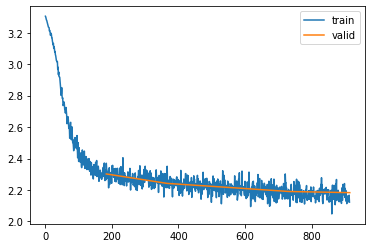

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 1000

# Hyperparameters
context_length = 3
n_h            = 50

dls = get_dls(bs, context_length)
rnn = VariableContextRNN(c2i, context_length, n_h)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

So it's doing a bit better (2.280 for the MLP, 2.217 for the RNN)

## Combing data: addition or concatenation

The first time I learned about the fact that we are simply adding activations from the hidden layer and the embedding layer, I was pretty surprised: how can you expect to get anything meaningful by simple adding activations from two layers together? As it turns out, in neural network literature it happens quite often that *combining of things* simply happens by element-wise addition.

However, we can also decide to concatenate these tensors instead. This means that our `hidden2hidden` layer needs to be updated 

In [ ]:
class VariableContextRNNConcat(nn.Module):
    
    def __init__(self, c2i, context_length, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.hidden2hidden  = nn.Linear(2*hidden_size, hidden_size)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)                # [bs, context_length, hidden_size]
        h = torch.zeros((x.shape[0], self.hidden_size)).to(device)
        
        for i in range(x.shape[1]):
            h = torch.cat([h, inputs[:,i,:]], dim=1) # [bs, 2 x hidden_size]
            h = F.relu(self.hidden2hidden(h))        # [bs, hidden_size]
        return self.hidden2out(h)                    # [bs, classes]

epoch,mode,loss
0,train,2.601
0,eval,2.292
1,train,2.262
1,eval,2.227
2,train,2.214
2,eval,2.195
3,train,2.179
3,eval,2.174
4,train,2.155
4,eval,2.165


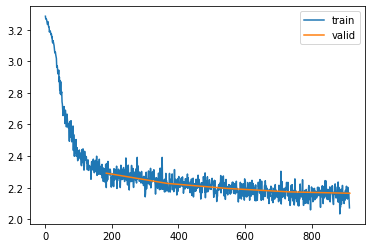

In [ ]:
rnn = VariableContextRNNConcat(c2i, context_length, n_h)

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

And this gives a slighly better performance

## PyTorch RNN:

We can also use `nn.RNN`, some notes:

- `nn.RNN` uses a tanh activation by default, we can use a relu activation instead by setting the `nonlinearity` argument
- the (dummy) activations that we add for the processing of the first token need to have an additional empty dimension in first position (for the non bidirectional case) according to the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- when forwarding data through the rnn module, it expects the input data to have the context_length as first dimension. By setting `batch_first=True` we change this behavior to having batch as first dimension
- `nn.RNN` returns two parameters. The first parameter is a tensor containing all the hidden activation (from each iteration), the second parameter has the final hidden activation. For the moment we are only interested in the last hidden activations and pass it to the output layer

In [ ]:
class PyTorchRNN(nn.Module):
    
    def __init__(self, c2i, context_length, hidden_size):
        super().__init__()
        self.c2i = c2i
        self.hidden_size = hidden_size
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        # RNN has by default tanh activation and the context length as first dimension
        self.rnn            = nn.RNN(hidden_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        # inputs: [1000, 3, 50]
        
        h = torch.zeros((1, x.shape[0], self.hidden_size)).to(device)
        
        hs, h = self.rnn(inputs, h)
        # hs : [1000, 3, 50]
        # h  : [1, 1000, 50]
        return self.hidden2out(h.squeeze(0))

epoch,mode,loss
0,train,2.602
0,eval,2.292
1,train,2.256
1,eval,2.230
2,train,2.210
2,eval,2.197
3,train,2.177
3,eval,2.172
4,train,2.153
4,eval,2.162


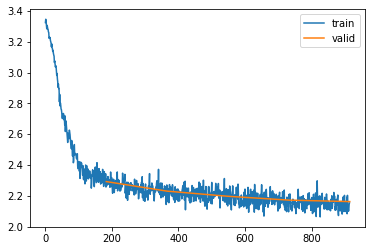

In [ ]:
rnn = PyTorchRNN(c2i, context_length, n_h)

l = Learner(rnn, dls, F.cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

## Optimizing dataloading and model for sequential data

Although the previous RNN's are perfectly valid models, there is a pretty big improvement we can make for the training of these models. To realize that, let's have a look at the samples for the first name in our dataset *Yuheng*:

In [ ]:
xb, yb = dls.train.dataset[0:6]
for x,y in zip(xb, yb):
    print(list(i2c[i.item()] for i in x), '-->' ,i2c[y.item()])

['.', '.', '.'] --> y
['.', '.', 'y'] --> u
['.', 'y', 'u'] --> h
['y', 'u', 'h'] --> e
['u', 'h', 'e'] --> n
['h', 'e', 'n'] --> g


Let's say we do a forward pass on these samples in order with a batch size of 1. For each forward pass, we reinitialize the dummy hidden layer activations, and the first two tokens we process are in fact already processed in the previous sample. We could be more efficient by just using the hidden activations we computed on the previous sample and have one iteration over the new token in the context:

![](rnn2.drawio.png){width=600}

Since this assymetry for the very first sample is not practical, let's simplify things and make the architecture symmetrical. At the same time, this means we can get rid of the 3 double start symbol (`...`) and just do with a single `.`.

![](rnn3.drawio.png){width=600}

Now, how are we going to feed this into a neural network? The dataloading needs to change quite drastically.

First, we need to go from samples (combinations of `X` and `y`) that look like this:

In [ ]:
#| code-fold: true
xb, yb = dls.train.dataset[0:7]
for x,y in zip(xb, yb):
    print(list(i2c[i.item()] for i in x), '-->' ,i2c[y.item()])

['.', '.', '.'] --> y
['.', '.', 'y'] --> u
['.', 'y', 'u'] --> h
['y', 'u', 'h'] --> e
['u', 'h', 'e'] --> n
['h', 'e', 'n'] --> g
['e', 'n', 'g'] --> .


to samples that simply look like this:

In [ ]:
#| code-fold: true
name = '.yuheng.'
for i in range(len(name)-1):
    print(f"['{name[i]}'] --> {name[i+1]}")

['.'] --> y
['y'] --> u
['u'] --> h
['h'] --> e
['e'] --> n
['n'] --> g
['g'] --> .


However, we want to keep the sequence length (context length) dimension and thus create a dataset that looks like this:

In [ ]:
#| code-fold: true
print("['.', 'y', 'u']", '-->', "['y', 'u', 'h']")
print("['h', 'e', 'n']", '-->', "['e', 'n', 'g']")

['.', 'y', 'u'] --> ['y', 'u', 'h']
['h', 'e', 'n'] --> ['e', 'n', 'g']


So let's create a new dataset for this purpose:

In [ ]:
class SequentialDataset():
    def __init__(self, lines, c2i, sequence_length):
        text = "." + ".".join(lines) + "."
        self.x = []
        self.y = []
        for i in range(0, len(text) - sequence_length - 1, sequence_length):
            self.x.append([c2i[xi] for xi in text[i: i+sequence_length]])
            self.y.append([c2i[yi] for yi in text[i+1: i+sequence_length+1]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)
    
train_ds = SequentialDataset(train_lines, c2i, 3)
valid_ds = SequentialDataset(val_lines, c2i, 3)

In [ ]:
for i in range(2):
    print([i2c[xi.item()] for xi in train_ds[i][0]], '-->', [i2c[xi.item()] for xi in train_ds[i][1]])

['.', 'y', 'u'] --> ['y', 'u', 'h']
['h', 'e', 'n'] --> ['e', 'n', 'g']


Furthermore, we need to order our data in a different way. 

First of all, we need to be very careful with shuffling: we certainly can't shuffle individual samples anymore in our Dataloader, since we need to maintain the sequence of our data. We could however shuffle the order of the (complete) names, at the beginning of each epoch. But let's not be concerned with that for now, and just disable shuffling altogether.

Also, we need to make sure that the stream *continues from sample to sample across batches*, so that we can pass the (final) hidden states from the samples in a batch to the samples in the next batch. 

![](rnn5.drawio.png){width=600}

If we order the data in this way, only the very first batch of each epoch will be using a dummy hidden state equal to zero, all other iterations in all the batches will be using the correct (previously computed and sequentially passed) hidden state.

To get these batches into the model during training, we need to order the data *vertically*, so 1, 21, 41, 61, 81, 2, 22, 42, etc. Let's do so in another dataset:

In [ ]:
class VerticalSampler():
    def __init__(self, ds, batch_size):
        self.batch_size = batch_size
        self.batches = len(ds) // self.batch_size
        
    def __iter__(self):
        for i in range(self.batches):
            for j in range(self.batch_size):
                yield i + self.batches*j
                
    def __len__(self):
        return self.batches * self.batch_size

Next, we can create a dataloader with the same batch size to load exactly the batches into the model as described.

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=VerticalSampler(train_ds, bs), batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=VerticalSampler(valid_ds, bs), batch_size=bs)

dls = DataLoaders(train_dl, valid_dl)

Now let's update our model to pass all the hidden states to the output layer:

In [ ]:
class PyTorchRNNMultiOutput(nn.Module):
    
    def __init__(self, c2i, context_length, hidden_size, bs):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.hidden_size = hidden_size
        self.register_buffer('h', torch.zeros((1, bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), hidden_size)
        self.rnn            = nn.RNN(hidden_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, h = self.rnn(inputs, self.h)
        # hs : [1000, 3, 50]
        # h  : [1, 1000, 50]
        self.h = h.detach()
        return self.hidden2out(hs)

And finally, we have to create a custom loss function that can deal with the multiple output activations (multiple) labels:

In [ ]:
def multi_output_cross_entropy(logits, targets):
    # logits = [1000, 3, 27]
    # targets = [1000, 3]
    
    targets = targets.view(-1)
    
    sl, bs, vocab_size = logits.shape
    logits = logits.view(-1, vocab_size)
    
    return F.cross_entropy(logits, targets)

In [ ]:
def get_dls(context_length, batch_size):
    train_ds = SequentialDataset(train_lines, c2i, context_length)
    valid_ds = SequentialDataset(val_lines, c2i, context_length)
        
    train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=Sampler(train_ds, batch_size), batch_size=batch_size)
    valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=Sampler(valid_ds, batch_size), batch_size=batch_size)

    return DataLoaders(train_dl, valid_dl)

Note that we drop the batch size to a value of 300 (1/3 of 1000). We do this, to roughly keep the amount of weight updates per batch constant. Previously, we had 1000 sequences in the batch, and from each sequence we would receive one update. Now, we have 3 times the amount of sequences in a batch, so we have to reduce the batch size by 3 to keep the amount of weight updates roughly equal.

epoch,mode,loss
0,train,2.549
0,eval,2.224
1,train,2.179
1,eval,2.171
2,train,2.118
2,eval,2.130
3,train,2.068
3,eval,2.099
4,train,2.029
4,eval,2.090


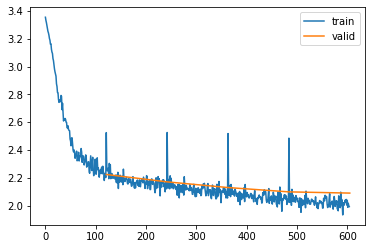

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, context_length, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device)]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

Performance is pretty good, however what's up with the spikes in the loss? These spikes occur at the beginning of every epoch and they happen because moving from the last batch in an epoch, to the first batch in the next epoch is not a sequential step in the data. Looking at the image above in which we laid out the "vertical ordering of the data", wee see that for the first batch in any epoch > 1, we would feed the hidden state originating from samples (20, 40, 60, 80, 100) into the samples (1, 21, 41, 61, 81), e.g.:

In [ ]:
frm = (20, 40, 60, 80, 100)
to  = (1, 21, 41, 61, 81)

for f, t in zip(frm,to):
    print(f'from: {f:3d} to: {t:2d}')

from:  20 to:  1
from:  40 to: 21
from:  60 to: 41
from:  80 to: 61
from: 100 to: 81


And this is obviously not sequential. The easiest solution is to reset the hidden state to zero at the beginning of each epoch, let's do this with a very small `Subscriber`:

:::{callout-note}}
Based on the observation that we could realign the hidden activations by moving them one row down, when starting a newe epoch I implemented this solution but was surprised to see that this doesn't improve things at all. I then found that we generally don't have a fully connected sequential dataset that fits exactly into a whole number of batches, we thus lose some data in the end, and the data doesn't connect easily by shifting it "one row down". In terms of the sample ordering diagram above: we generally don't have (20, 40, 60, 80, 100) as final batch of an epoch but instead something like (18, 38, 58, 78, 98).
:::

In [ ]:
class HiddenStateResetterS(Subscriber):
    def before_epoch(self, learn):
        learn.model.reset_hidden_state()
        
@fc.patch
def reset_hidden_state(self:PyTorchRNNMultiOutput):
    device = self.h.get_device()
    self.h = torch.zeros_like(self.h).to(device)

epoch,mode,loss
0,train,2.538
0,eval,2.218
1,train,2.178
1,eval,2.163
2,train,2.118
2,eval,2.116
3,train,2.068
3,eval,2.085
4,train,2.030
4,eval,2.076


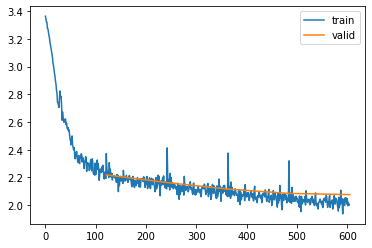

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, context_length, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

The loss improved a bit from this fix, and the spikes are smaller, but still visible. This is not surprising since the very first batch in each epoch still has the difficulty of working with an empty hidden state. This is not a big issue however, since the hidden state is quickly filling up and accordingly the following batches show again a loss that is in-line with the end of the previous epoch.

Last but not least, PyTorch `nn.RNN` accepts two parameters, one for the features in the inputs and one for the features in the hidden state. Previously we made used one single parameter for this (hidden_size), let's pull them apart and see whether we can further improve performance through tweaking of these 2 parameters:

In [ ]:
class PyTorchRNNMultiOutput(nn.Module):
    
    def __init__(self, c2i, context_length, embedding_dim, hidden_size, bs):
        super().__init__()
        self.c2i = c2i
        self.bs = bs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.register_buffer('h', torch.zeros((1, bs, self.hidden_size)))
        
        self.input2hidden   = nn.Embedding(len(c2i), embedding_dim)
        self.rnn            = nn.RNN(embedding_dim, hidden_size, nonlinearity='relu', batch_first=True)
        self.hidden2out     = nn.Linear(hidden_size, len(c2i))
        
    def forward(self, x):
        inputs = self.input2hidden(x)
        hs, h = self.rnn(inputs, self.h)
        # hs : [1000, 3, 50]
        # h  : [1, 1000, 50]
        self.h = h.detach()
        return self.hidden2out(hs)
    
    def reset_hidden_state(self):
        device = self.h.get_device()
        self.h = torch.zeros_like(self.h).to(device)

epoch,mode,loss
0,train,2.396
0,eval,2.167
1,train,2.132
1,eval,2.123
2,train,2.041
2,eval,2.052
3,train,1.930
3,eval,2.003
4,train,1.823
4,eval,1.984


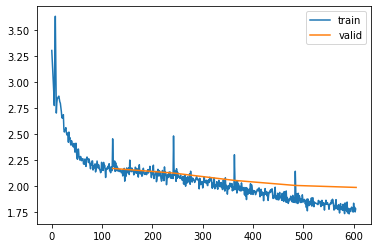

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-2
bs     = 300

# Hyperparameters
context_length = 5
n_h            = 1000
embedding_dim  = 100

dls = get_dls(context_length, bs)
rnn = PyTorchRNNMultiOutput(c2i, context_length, embedding_dim, n_h, bs)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        HiddenStateResetterS()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(rnn, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

Trying for around 10 minuts with different settings shows me that performance can be gained on this dataset by 